## Traffic Sign Recognition Classifier

---
## Load The Data

**Note: ** I copied some files around to make my readTrafficSigns function work for both training and test sets.

Take a look at the test_file / training_file variables as a guide 

[Training Data](http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip)

[Test Data](http://benchmark.ini.rub.de/Dataset/GTSRB_Online-Test-Images-Sorted.zip)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pickle
import csv
import pandas as pd
from sklearn import metrics, model_selection


training_file = "./traffic-signs-data/train/Images"
test_file = "./traffic-signs-data/test/Images"

In [3]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [4]:
x_train, y_train = readTrafficSigns(training_file)
x_test, y_test = readTrafficSigns(test_file)

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

### Visualize the dataset

Image classification integer:  7


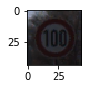

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

index = random.randint(0, len(x_train))
image = x_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print('Image classification integer: ', y_train[index])

----

## Step 2: Design and Test a Model Architecture

### Import tensorflow and define constants

In [6]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 512
KEEP_PROB = .80
LEARNING_RATE = 0.001
COLOR_CHANNELS = 3

### Augment dataset

This originally added some skew, but now it just scales the images to 32x32, the original images came in various dimensions.

In [8]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Scale({"height":32, "width":32})
], random_order=True) # apply augmenters in random order

In [9]:
augmented_x_train = np.array(seq.augment_images(x_train))
augmented_y_train = y_train
x_test = np.array(seq.augment_images(x_test))
print("Number of training examples =", augmented_x_train.shape[0])

Number of training examples = 39209


### Preprocess data

In [10]:
def normalize(x_train):
    x_train = np.array(x_train)
    x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
    return x_train

In [11]:
def rgb_to_greyscale(image):
    return np.dot(image[...,:3], [0.299, 0.587, 0.114])

In [12]:
from sklearn.utils import shuffle
def process_data(x_data, y_data):
    if COLOR_CHANNELS == 1:
        x_data = rgb_to_greyscale(x_data)
        x_data = x_data.reshape(x_data.shape + (1,))
    x_data = normalize(x_data)
    x_data, y_data = shuffle(x_data, y_data)
    return (x_data, y_data)

In [13]:
x_train, y_train = process_data(augmented_x_train, augmented_y_train)
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train, test_size=0.2)
x_test, y_test = process_data(x_test, y_test)

In [14]:
n_classes = len(set(y_train))

### Model Architecture

In [20]:
from tensorflow.contrib.layers import flatten

def traffic_signs(x):    
    mu = 0
    sigma = 0.1
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, COLOR_CHANNELS, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    conv2 = tf.nn.relu(conv2)
    fc0   = flatten(conv2)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, KEEP_PROB)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    fc2    = tf.nn.relu(fc2)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [21]:
x = tf.placeholder(tf.float32, (None, 32, 32, COLOR_CHANNELS))
y = tf.placeholder(tf.int32, (None))
pred = traffic_signs(x)
one_hot_y = tf.one_hot(y, n_classes)

logits = traffic_signs(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = np.array(x_train[offset:end]), np.array(y_train[offset:end])
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(x_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic_lights')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.545

EPOCH 2 ...
Validation Accuracy = 0.760

EPOCH 3 ...
Validation Accuracy = 0.861

EPOCH 4 ...
Validation Accuracy = 0.882

EPOCH 5 ...
Validation Accuracy = 0.913

EPOCH 6 ...
Validation Accuracy = 0.924

EPOCH 7 ...
Validation Accuracy = 0.935

EPOCH 8 ...
Validation Accuracy = 0.945

EPOCH 9 ...
Validation Accuracy = 0.948

EPOCH 10 ...
Validation Accuracy = 0.946

Model saved
